In [1]:
import numpy as np
import tensorflow as tf
import os, glob
import matplotlib.pyplot as plt
from PIL import Image
from celluloid import Camera
from IPython.display import HTML
import collections.abc
from matplotlib.gridspec import GridSpec
import ExoRIM as exo
import xara
import pickle
import matplotlib
%matplotlib inline

In [2]:
os.chdir("..")
basedir = os.getcwd()
basedir

'/home/alexandre/Desktop/Projects/ExoRIM'

In [17]:
id = "20-08-20_12-14-17"
results_dir = os.path.join(basedir, "results", id)
checkpoints_dir = os.path.join(basedir, "models", id)
train_data_dir = os.path.join(basedir, "data", id, "train")
test_data_dir = os.path.join(basedir, "data", id, "test")

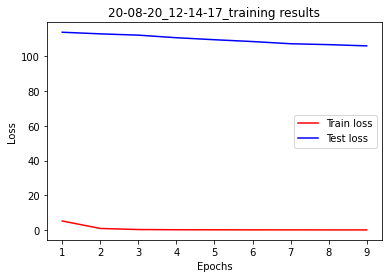

In [18]:
train_loss = np.loadtxt(os.path.join(results_dir, "train_loss.txt"))
test_loss = np.loadtxt(os.path.join(results_dir, "test_loss.txt"))
epochs = [i for i in range(1, train_loss.size + 1)]
plt.figure()
plt.plot(epochs, train_loss, "-r", label="Train loss")
plt.plot(epochs, test_loss, "-b", label="Test loss")
plt.title(id + "_training results")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(results_dir, "learning_curve.png"))

In [135]:
test_loss.min()

42.1665153503418

In [19]:
# update of nested dictionaries
def update(d, u):
    for k, v in u.items():
        if isinstance(v, collections.abc.Mapping):
            d[k] = update(d.get(k, {}), v)
        else:
            d[k] = v
    return d

images = {}
for file in glob.glob(os.path.join(results_dir, "output*")):
    name = os.path.split(file)[-1]
    if name[-3:] == "png":
        epoch = int(name[7:10])
        index = int(name[11:15])
        step = int(name[16:18])
        with Image.open(file) as image:
            im = np.array(image.getdata()).reshape([image.size[0], image.size[1]])
            update(images, {index: {epoch : {step: im}}})
    elif name[-3:] == "txt":
        epoch = int(name[7:11])
        index = int(name[12:16])
        step = int(name[17:19])
        im = np.loadtxt(file)
        update(images, {index: {epoch : {step: im}}})
images.keys()

dict_keys([60, 20, 40, 0, 80])

In [20]:
log_grad = {}
for file in glob.glob(os.path.join(results_dir, "grad_[0-9]*")):
    name = os.path.split(file)[-1]
    epoch = int(name[5:9])
    index = int(name[10:14])
    step = int(name[15:17])
    g = np.loadtxt(file)
    update(log_grad, {index: {epoch : {step: g}}})
with open(os.path.join(results_dir, "grad_and_weights.pickle"), "rb") as f:
    grad_and_weights = pickle.load(f)

In [21]:
ground_truth = {}
for file in glob.glob(os.path.join(train_data_dir, "image_[0-9]*")):
    name = os.path.split(file)[-1]
    epoch = int(name[6:10])
    index = int(name[11:-4])
    if name[-3:] == "png":
        with Image.open(file) as image:
            im = np.array(image.getdata()).reshape(image.size[0], image.size[1])
            ground_truth[index] = im
    elif name[-3:] == "txt":
        ground_truth[index] = np.loadtxt(file)
ground_truth.keys()

dict_keys([60, 20, 40, 80, 0])

In [37]:
%%capture

index = 80
# index = 50
step = 7
# step = 11
fig = plt.figure()
cam = Camera(fig)
selected_image = images[index]
for key in sorted(list(selected_image.keys())):
    plt.imshow(selected_image[key][step], cmap="gray")
    cam.snap()
animation = cam.animate()
animation.save(os.path.join(results_dir, "output.mp4"), writer="ffmpeg")
anim1 = HTML(animation.to_html5_video())

In [38]:
%%capture
fig = plt.figure()
cam = Camera(fig)
for key in sorted(list(selected_image.keys())):
    plt.imshow((ground_truth[index] - selected_image[key][step]), cmap="gray")
    cam.snap()
animation = cam.animate()
animation.save(os.path.join(results_dir, "residual.mp4"), writer="ffmpeg")
anim2 = HTML(animation.to_html5_video())

In [39]:
%%capture

fig = plt.figure()
cam = Camera(fig)
selected_grad = log_grad[index]
for key in sorted(list(selected_grad.keys())):
    plt.imshow(selected_grad[key][step])
    cam.snap()
animation = cam.animate()
animation.save(os.path.join(results_dir, "log_likelihood_grad.mp4"), writer="ffmpeg")
anim3 = HTML(animation.to_html5_video())

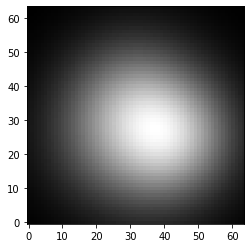

In [40]:
plt.figure()
plt.imshow(ground_truth[index], cmap="gray")
plt.savefig(os.path.join(results_dir, "ground_truth.png"))

In [41]:
# Output
anim1

In [35]:
# Residual
anim2

In [42]:
# likelihood grad
anim3

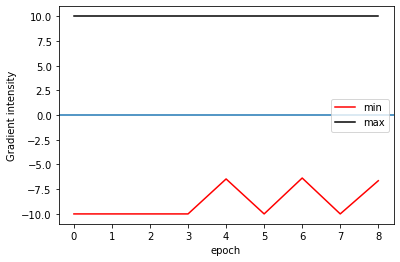

In [28]:
fig = plt.figure()
mi = []
ma = []
for key in sorted(list(selected_grad.keys())):
    mi.append(selected_grad[key][step].min())
    ma.append(selected_grad[key][step].max())
plt.axhline(0)
plt.plot(list(range(len(mi))), mi, "r-", label="min")
plt.plot(list(range(len(mi))), ma, "k-", label="max")
plt.xlabel("epoch")
plt.ylabel("Gradient intensity")
plt.legend()
plt.show()

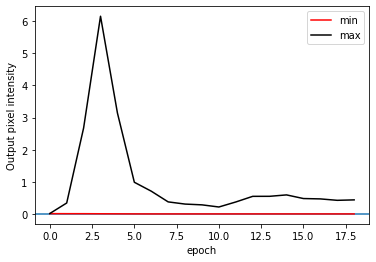

In [121]:
mi = []
ma = []
for key in sorted(list(selected_image.keys())):
    mi.append(selected_image[key][step].min())
    ma.append(selected_image[key][step].max())
plt.axhline(0)
plt.plot(list(range(len(mi))), mi, "r-", label="min")
plt.plot(list(range(len(mi))), ma, "k-", label="max")
plt.xlabel("epoch")
plt.ylabel("Output pixel intensity")
plt.legend()
plt.show()
# selected_image[1][2].max()

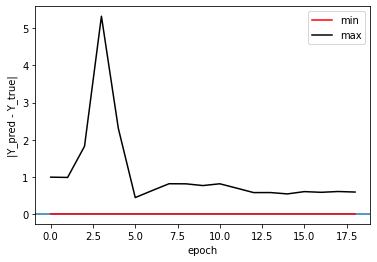

In [122]:

fig = plt.figure()
mi = []
ma = []
for key in sorted(list(selected_image.keys())):
    mi.append(np.abs(selected_image[key][step] - ground_truth[index]).min())
    ma.append(np.abs(selected_image[key][step] - ground_truth[index]).max())
plt.axhline(0)
plt.plot(list(range(len(mi))), mi, "r-", label="min")
plt.plot(list(range(len(mi))), ma, "k-", label="max")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("|Y_pred - Y_true|")
plt.show()

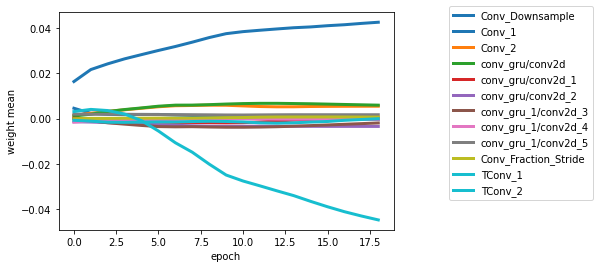

In [123]:
batch = 0
# map_layer_to_depth = {
#     "model/Conv_Downsample": 0,
#     "model/Conv_1": 1,
#     "model/conv_gru/conv2d": 2,
#     "model/conv_gru/conv2d_1": 3,
#     "model/conv_gru/conv2d_2": 4,
#     "model/conv_gru_1/conv2d_3": 5,
#     "model/conv_gru_1/conv2d_4": 6,
#     "model/conv_gru_1/conv2d_5": 7,
#     "model/Conv_Fraction_Stride": 8,
#     "model/TConv_1": 9
# }
map_layer_to_depth = {
    "model/Conv_Downsample": 0,
    "model/Conv_1": 1,
    "model/Conv_2": 2,
    "model/conv_gru/conv2d": 3,
    "model/conv_gru/conv2d_1": 4,
    "model/conv_gru/conv2d_2": 5,
    "model/conv_gru_1/conv2d_3": 6,
    "model/conv_gru_1/conv2d_4": 7,
    "model/conv_gru_1/conv2d_5": 8,
    "model/Conv_Fraction_Stride": 9,
    "model/TConv_1": 10,
    "model/TConv_2": 11
}
inv_map = {v: k for k, v in map_layer_to_depth.items()}

kernel_weight_var = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_weight_mean = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_grad_mean = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_grad_var = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_weight_max = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
kernel_weight_min = [[] for _ in range(max(map_layer_to_depth.values()) + 1)]
for layer_name in grad_and_weights.keys():
    if "kernel" in layer_name:
        layer = layer_name[:-len("/kernel:0")]
        depth = map_layer_to_depth[layer]
        for epoch, d in grad_and_weights[layer_name].items():
            kernel_weight_mean[depth].append(d[batch]["weight_mean"])
            kernel_weight_var[depth].append(d[batch]["weight_var"])
            kernel_grad_mean[depth].append(d[batch]["grad_mean"])
            kernel_grad_var[depth].append(d[batch]["grad_var"])
            kernel_weight_max[depth].append(d[batch]["weight_max"])
            kernel_weight_min[depth].append(d[batch]["weight_min"])
cmap = matplotlib.cm.get_cmap("tab10")
norm = matplotlib.colors.Normalize(vmin=0, vmax=max(map_layer_to_depth.values()))
for depth, data in enumerate(kernel_weight_mean):
    plt.plot(list(range(len(data))), data, c=cmap(norm(depth)), label=inv_map[depth][len("model/"):], lw=3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xlabel("epoch")
plt.ylabel("weight mean")
plt.savefig(os.path.join(results_dir, "weight_mean.png"))
# name: epoch: batch: stats

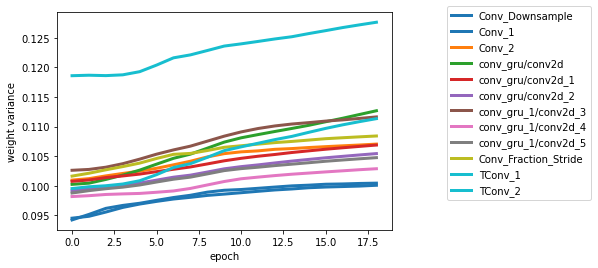

In [124]:
for depth, data in enumerate(kernel_weight_var):
    plt.plot(list(range(len(data))), data, c=cmap(norm(depth)), label=inv_map[depth][len("model/"):], lw=3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xlabel("epoch")
plt.ylabel("weight variance")
plt.savefig(os.path.join(results_dir, "weight_var.png"))

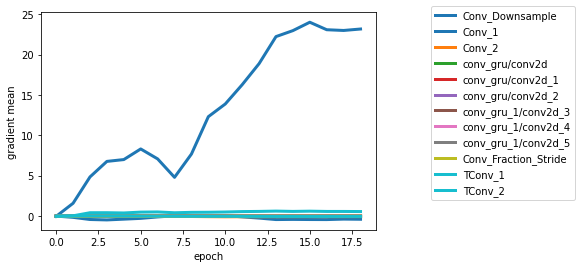

In [125]:
# cmap = matplotlib.cm.get_cmap("seismic")
# norm = matplotlib.colors.Normalize(vmin=0, vmax=max(map_layer_to_depth.values()))
for depth, data in enumerate(kernel_grad_mean):
    plt.plot(list(range(len(data))), data, c=cmap(norm(depth)), label=inv_map[depth][len("model/"):], lw=3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xlabel("epoch")
plt.ylabel("gradient mean")
plt.savefig(os.path.join(results_dir, "backpropgrad_mean.png"))

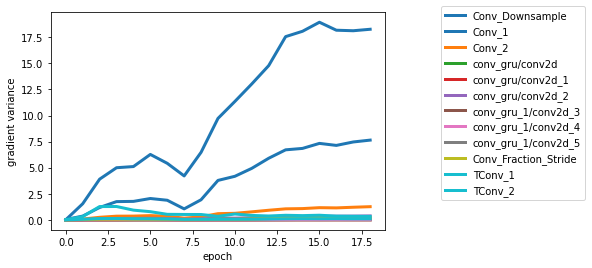

In [126]:
for depth, data in enumerate(kernel_grad_var):
    plt.plot(list(range(len(data))), data, c=cmap(norm(depth)), label=inv_map[depth][len("model/"):], lw=3)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xlabel("epoch")
plt.ylabel("gradient variance")
plt.savefig(os.path.join(results_dir, "backpropgrad_var.png"))

1225 distinct baselines found. Mask has 0 redundant baselines
There are 1176 independant closure phases and 19600 total closure phases
172.26418
tf.Tensor(173.0255, shape=(), dtype=float32)
0.32690492


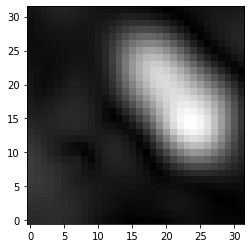

In [130]:
np.random.seed(42)
N = 50
wavel = 0.5e-6
pad = 0
pix = 32 + 0*pad
L = 6
plate_scale = 3.2
m = 1
SNR = 100
circle_mask = np.zeros((N, 2))
for i in range(N):
    circle_mask[i, 0] = (L + np.random.normal(0, m)) * np.cos(2 * np.pi * i / N)
    circle_mask[i, 1] = (L + np.random.normal(0, m)) * np.sin(2 * np.pi * i / N)
random_mask = np.random.normal(size=(N, 2))
image_coords = np.arange(pix) - pix / 2.
xx, yy = np.meshgrid(image_coords, image_coords)
image = np.zeros_like(xx)
rho_squared = (xx - 5) ** 2 + (yy) ** 2
image += rho_squared == 0
rho_squared = (xx + 5) ** 2 + (yy) ** 2
image += np.exp(rho_squared / 5**2)
im = ground_truth[index] #np.pad(image, ((pad, pad), (pad, pad)), constant_values=(0, 0))
# im = np.pad(image, ((pad, pad), (pad, pad)), constant_values=(0, 0))
# plt.imshow(image, cmap="gray")
# baselines = exo.operators.Baselines(mask_coordinates=circle_mask)
# cpo = exo.operators.phase_closure_operator(baselines)
# dftm = exo.operators.NDFTM(baselines.UVC, wavel, pix, plate_scale)
# dftm_i = exo.operators.NDFTM(baselines.UVC, wavel, pix, plate_scale, inv=True)
# m2pix = exo.definitions.mas2rad(plate_scale) * pix / wavel
# phys = PhysicalModel(circle_mask, hyperparameters["pixels"], visibility_noise=1e-3, cp_noise=1e-5, m2pix=m2pix)
phys = exo.physical_model.PhysicalModel(pix, circle_mask, wavel, plate_scale, SNR)
pad2 = -pad if pad != 0 else None 
forward = phys.forward(np.reshape(im, [-1, pix, pix, 1]))
reconstructed_image = np.dot(phys.A_adjoint, forward[0, :phys.p].numpy())
plt.imshow(np.reshape(np.abs(reconstructed_image), [pix, pix])[pad:pad2, pad:pad2], cmap="gray")
print(np.abs(reconstructed_image).max())
print(tf.math.reduce_logsumexp(np.abs(reconstructed_image)))
print(np.abs(reconstructed_image).min())
plt.savefig(os.path.join(results_dir, "dirty_image.png"))

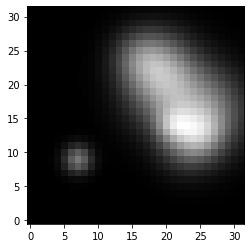

In [131]:
plt.imshow(im, cmap="gray")

In [132]:
b = np.sqrt(baselines.UVC[:, 0]**2 + baselines.UVC[:, 1]**2)
bx = baselines.UVC[:, 0]
by = baselines.UVC[:, 1]
xara.core.rad2mas(wavel/2/b.max())
plt.plot(b, np.abs(forward[0, :phys.p])/np.pi, "k.")
plt.ylabel("Visibility amplitude")
plt.xlabel("Baseline")

NameError: name 'baselines' is not defined

In [ ]:
m2pix = exo.definitions.mas2rad(plate_scale) * 32 / wavel
1.22 * 12/m2pix/2/np.pi

In [ ]:
basel = np.sqrt(phys.baselines.UVC[:, 0]**2 + phys.baselines.UVC[:, 1]**2)
basel.max()